# Alternative models
After getting a 56% F1 score from the MobileNetV2 Neural Network, that becomes sort of a benchmark for me.<br>
Now I will try alternative models to see if any of them can perform better or close to the performance of the Neural Network.

## Logistic Regression
Being the most traditional and common method of classification, I wanted to try out logistic regression to see if it would be effective at solving this case.

In [5]:
#############################################
# Chunk 1: Imports, Seeds, and Setup
#############################################
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#############################################
# Chunk 2: Data Collection and Label Encoding
#############################################
def get_image_paths_and_labels(directory):
    file_paths = []
    labels = []
    # List subdirectories (classes) in sorted order
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for file in os.listdir(cls_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(cls_dir, file))
                labels.append(cls)
    return pd.DataFrame({'file_path': file_paths, 'label': labels})

# Define the copied training directory (adjust path as needed)
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
df = get_image_paths_and_labels(new_train_dir)
print("Sample image paths and labels:")
print(df.head())

# Encode labels into numerical values
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

Sample image paths and labels:
                                           file_path      label
0  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
1  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
2  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
3  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
4  intel_dataset_copy/seg_train/seg_train/buildin...  buildings


In [6]:
#############################################
# Chunk 3: Feature Extraction using MobileNetV2
#############################################
# Load MobileNetV2 pre-trained on ImageNet without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
# Use Global Average Pooling to create a fixed-length feature vector
gap = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=gap)

def extract_features(file_path, target_size=(150,150)):
    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array, verbose=0)
    return features.flatten()

# Extract features for all images (using a progress bar)
features = []
for path in tqdm(df['file_path'], desc="Extracting features"):
    feat = extract_features(path)
    features.append(feat)
features = np.array(features)
print("Extracted features shape:", features.shape)

#############################################
# Chunk 4: Feature Scaling
#############################################
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2767/4208200367.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
Extracting features: 100%|████████████████████████████████████| 14016/14016 [13:01<00:00, 17.94it/s]


Extracted features shape: (14016, 1280)


In [7]:
#############################################
# Chunk 5: K-Fold Splitting and Logistic Regression Training
#############################################
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(features_scaled, df['label_encoded']))
print(f"Total number of folds: {len(folds)}")

fold_f1_scores = []
fold_reports = []

fold = 1
for train_idx, test_idx in folds:
    print(f"\n--- Fold {fold} ---")
    X_train_fold, X_test_fold = features_scaled[train_idx], features_scaled[test_idx]
    y_train_fold, y_test_fold = df['label_encoded'].values[train_idx], df['label_encoded'].values[test_idx]
    
    # Define logistic regression with L2 regularization and tune hyperparameter C
    logreg = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
    grid.fit(X_train_fold, y_train_fold)
    
    print("Best parameters for fold", fold, ":", grid.best_params_)
    y_pred_fold = grid.predict(X_test_fold)
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')
    print("Fold", fold, "Weighted F1 Score:", f1)
    fold_f1_scores.append(f1)
    
    report = classification_report(y_test_fold, y_pred_fold, target_names=le.classes_)
    print("Fold", fold, "Classification Report:\n", report)
    fold_reports.append(report)
    
    fold += 1

avg_f1 = np.mean(fold_f1_scores)
print("\nAverage Weighted F1 Score across folds:", avg_f1)

Total number of folds: 5

--- Fold 1 ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for fold 1 : {'C': 0.01}
Fold 1 Weighted F1 Score: 0.917793178878476
Fold 1 Classification Report:
               precision    recall  f1-score   support

   buildings       0.93      0.95      0.94       438
      forest       0.99      0.97      0.98       454
     glacier       0.85      0.84      0.85       481
    mountain       0.87      0.86      0.87       501
         sea       0.94      0.96      0.95       454
      street       0.94      0.95      0.94       476

    accuracy                           0.92      2804
   macro avg       0.92      0.92      0.92      2804
weighted avg       0.92      0.92      0.92      2804


--- Fold 2 ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for fold 2 : {'C': 0.01}
Fold 2 Weighted F1 Score: 0.9058695333295343
Fold 2 Classification Report:
               precision    recall  f1-score   s

**Use cross_val_predict to Aggregate Predictions**

This approach uses scikit‑learn’s cross_val_predict to perform K‑Fold CV and generate predictions for every sample, which you can then use to compute the confusion matrix.

[CV] END ..............................................C=0.1; total time= 1.4min
[CV] END ................................................C=1; total time= 2.4min
[CV] END ..............................................C=100; total time= 3.2min
[CV] END .............................................C=0.01; total time=  53.4s
[CV] END ................................................C=1; total time= 2.2min
[CV] END ...............................................C=10; total time= 2.9min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ................................................C=1; total time= 2.8min
[CV] END ..............................................C=100; total time= 3.0min
[CV] END .............................................C=0.01; total time= 1.2min
[CV] END ..............................................C=0.1; total time= 1.3min
[CV] END ...............................................C=10; total time= 3.3min
[CV] END ...................

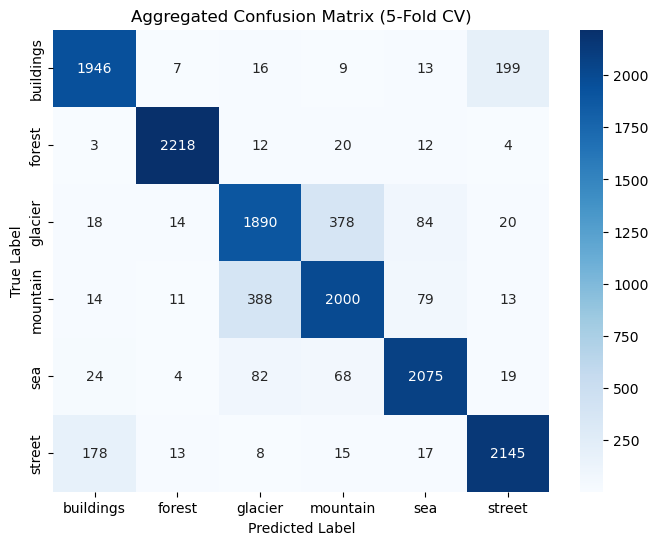

Aggregated Classification Report:
              precision    recall  f1-score   support

   buildings       0.89      0.89      0.89      2190
      forest       0.98      0.98      0.98      2269
     glacier       0.79      0.79      0.79      2404
    mountain       0.80      0.80      0.80      2505
         sea       0.91      0.91      0.91      2272
      street       0.89      0.90      0.90      2376

    accuracy                           0.88     14016
   macro avg       0.88      0.88      0.88     14016
weighted avg       0.88      0.88      0.88     14016

Aggregated Weighted F1 Score: 0.8756295191928755


In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Use the entire features_scaled and labels from df
y_true_all = df['label_encoded'].values
# Create a logistic regression model (without hyperparameter tuning for simplicity)
logreg = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)

# Get cross-validated predictions
y_pred_all = cross_val_predict(logreg, features_scaled, y_true_all, cv=5)

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Aggregated Confusion Matrix (5-Fold CV)')
plt.show()

print("Aggregated Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))
print("Aggregated Weighted F1 Score:", f1_score(y_true_all, y_pred_all, average='weighted'))

Visualizations based on the best Logistic regression model's fold

In [15]:
# Assuming you choose a hyperparameter value from your grid search results
best_C = 0.01  # Replace with the optimal value found during grid search
final_logreg = LogisticRegression(max_iter=500, solver='liblinear', random_state=42, C=best_C)
final_logreg.fit(features_scaled, df['label_encoded'])

LogisticRegression(C=0.01, max_iter=500, random_state=42, solver='liblinear')

/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2767/93033848.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))


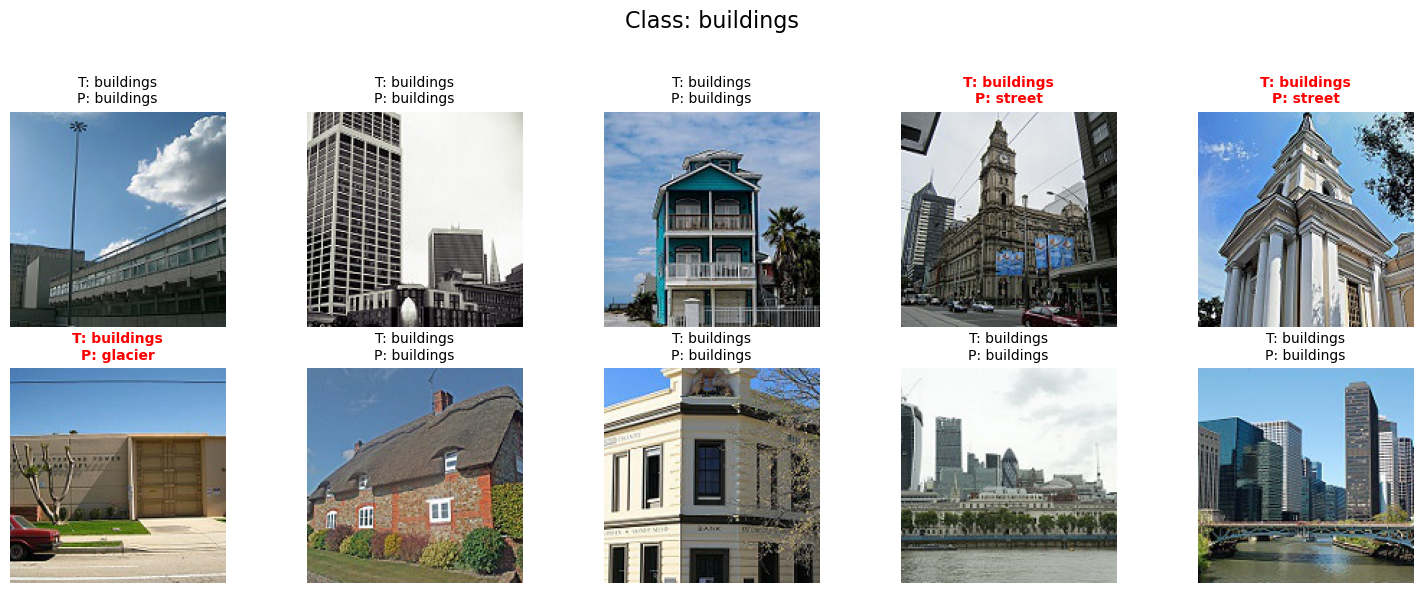

--------------------------------------------------------------------------------


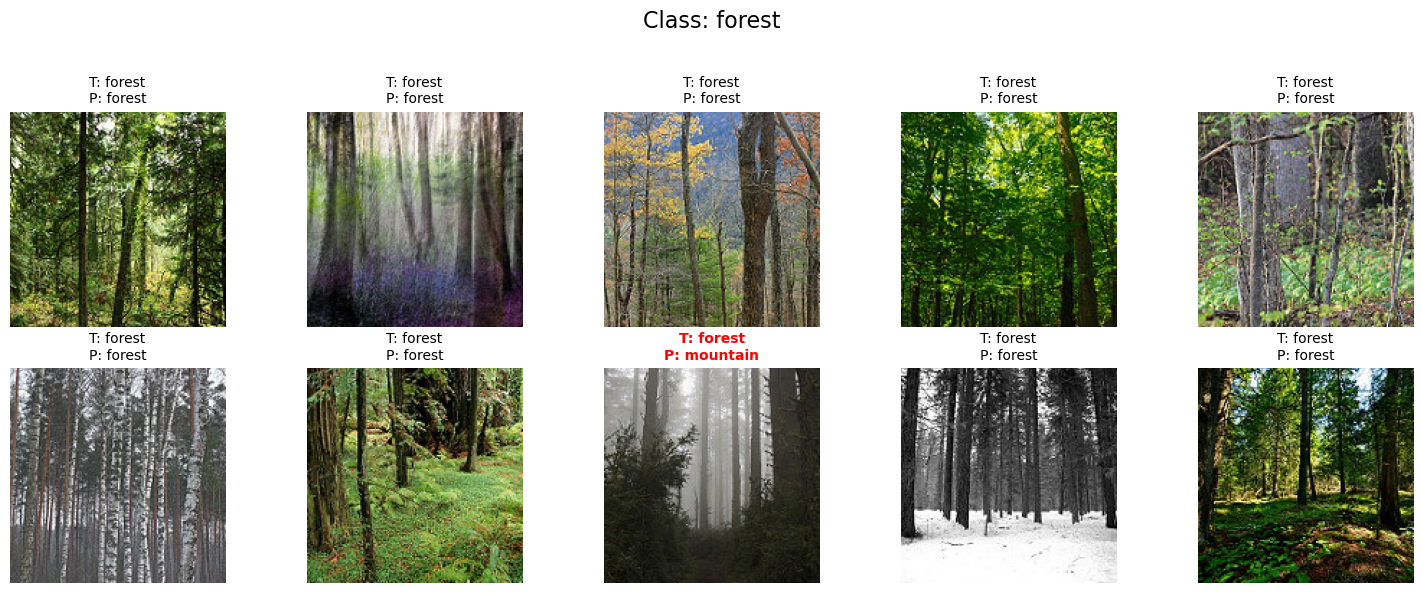

--------------------------------------------------------------------------------


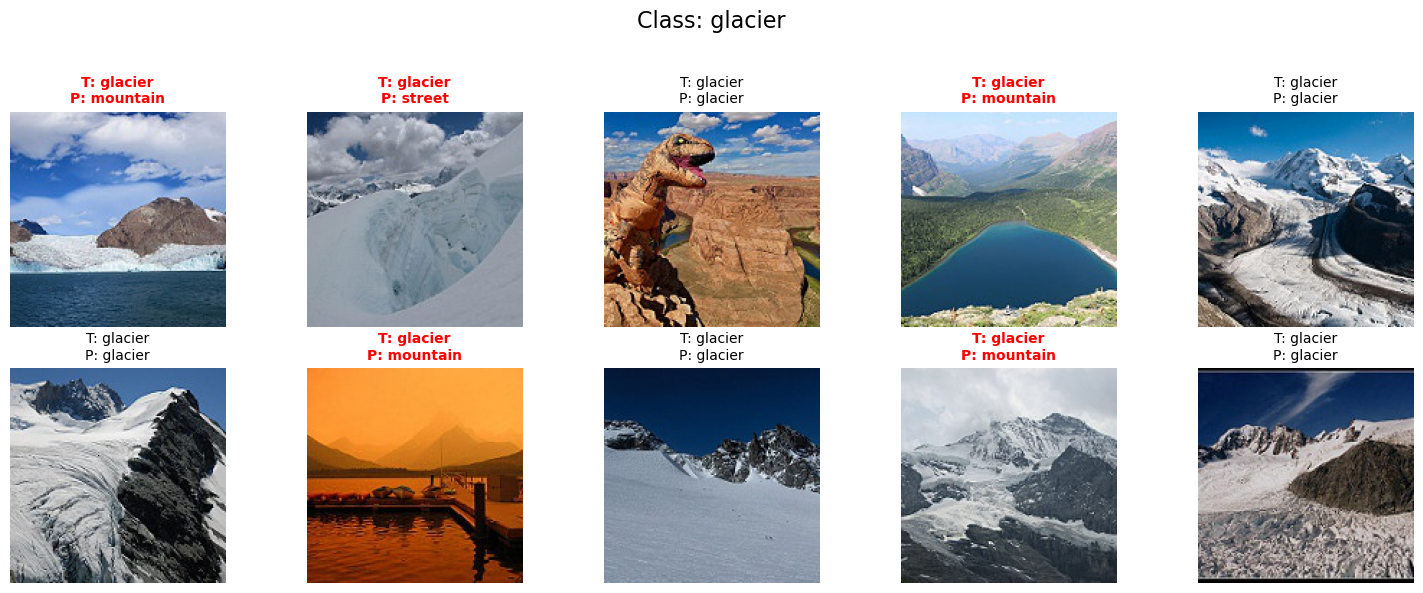

--------------------------------------------------------------------------------


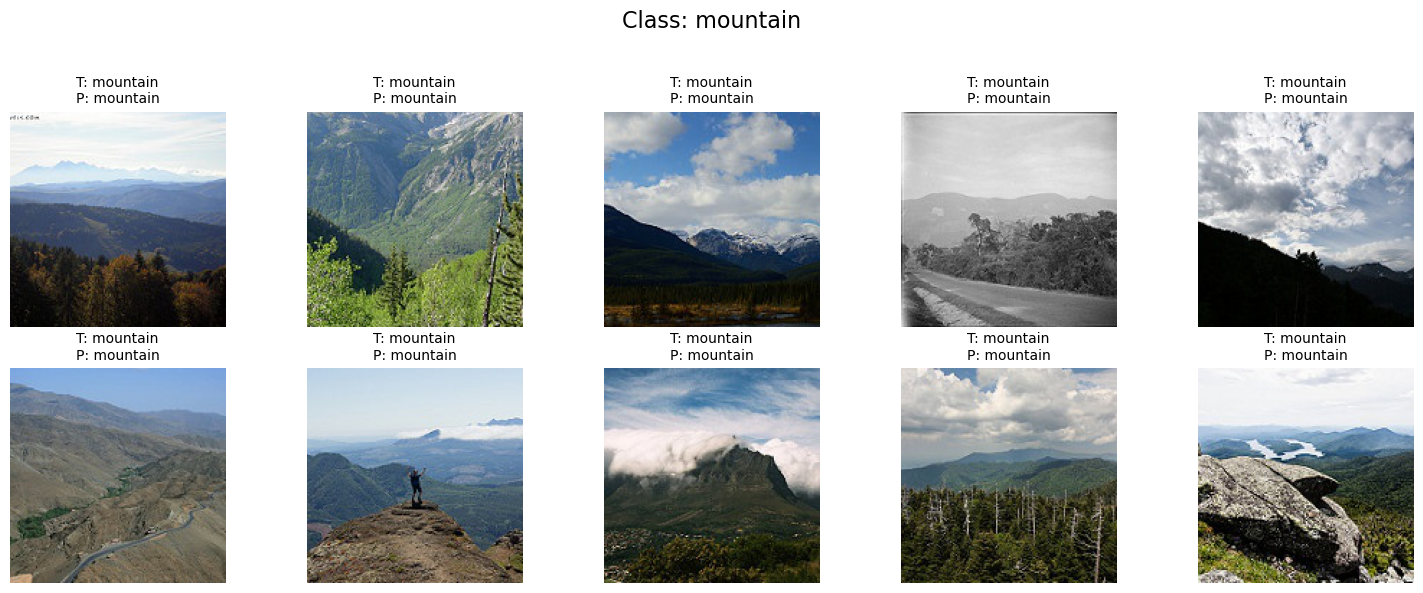

--------------------------------------------------------------------------------


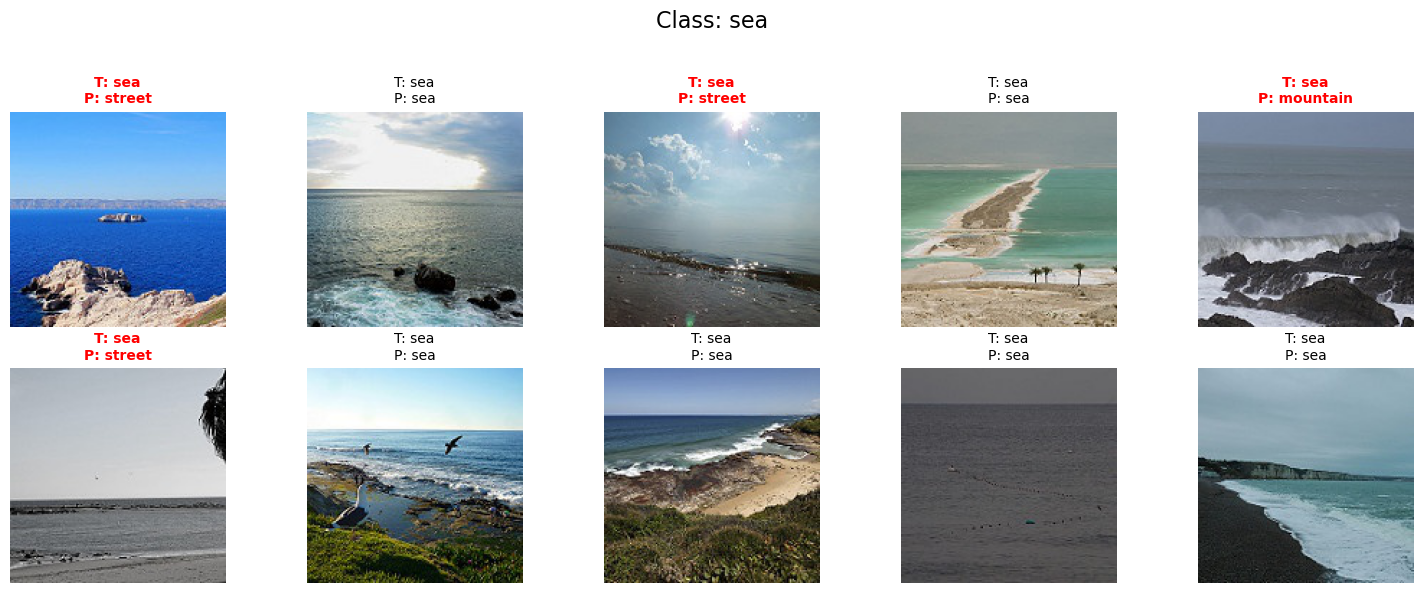

--------------------------------------------------------------------------------


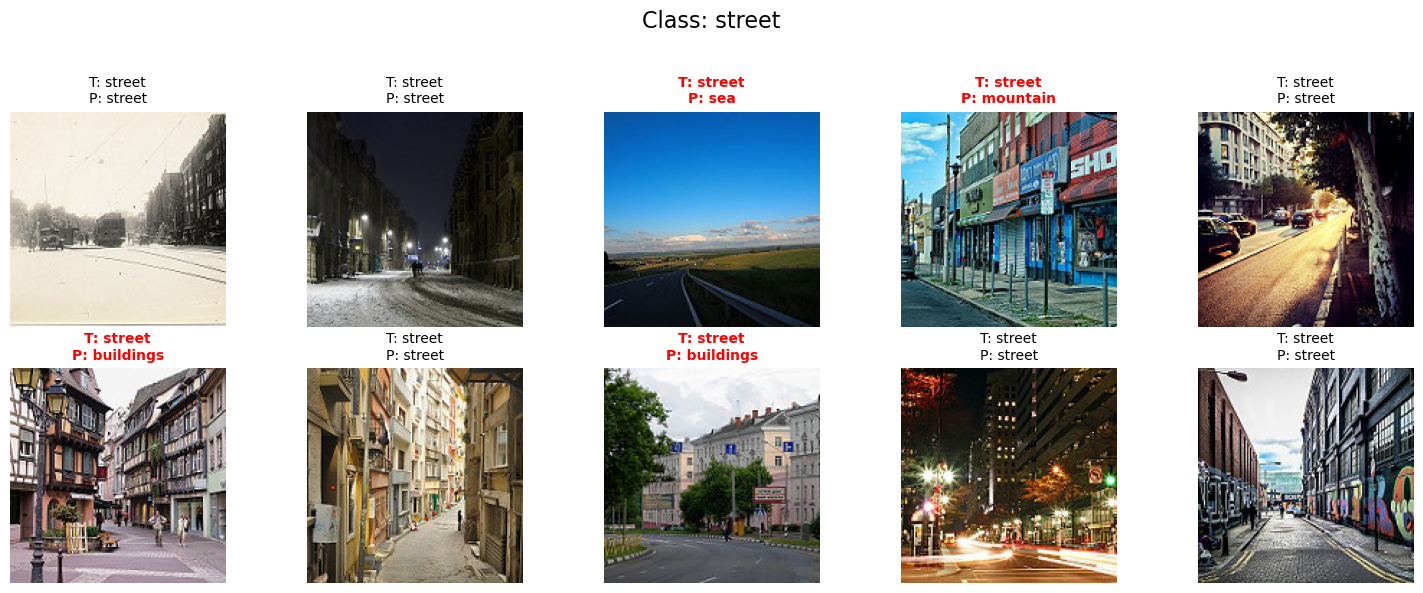

--------------------------------------------------------------------------------


In [17]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
random.seed(42)

# Build a global feature extractor using MobileNetV2 (with fixed input shape)
def build_feature_extractor(target_size=(150,150)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    gap = GlobalAveragePooling2D()(base_model.output)
    feature_extractor = Model(inputs=base_model.input, outputs=gap)
    return feature_extractor

feature_extractor = build_feature_extractor(target_size=(150,150))

# Define extract_features that reuses the global feature_extractor
def extract_features(file_path, target_size=(150,150)):
    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array, verbose=0)
    return features.flatten()

# Fit a new StandardScaler on one sample per class from the test set
new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')
classes = sorted([d for d in os.listdir(new_test_dir) if os.path.isdir(os.path.join(new_test_dir, d))])
sample_features = []
for cls in classes:
    class_dir = os.path.join(new_test_dir, cls)
    # Get a sorted list of image files for consistency
    images = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if images:
        sample_path = os.path.join(class_dir, images[0])
        feat = extract_features(sample_path, target_size=(150,150))
        sample_features.append(feat)
# Force full shape resolution with np.stack
sample_features = np.stack(sample_features, axis=0)
scaler = StandardScaler()
scaler.fit(sample_features)

# Visualization function for logistic regression predictions
def display_logreg_predictions(num_images=10, rows=2, cols=5, target_size=(150,150)):
    # Set random seed for reproducibility
    random.seed(42)
    
    # Define the copied test directory
    new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')
    # Get sorted list of classes in the test set
    classes = sorted([d for d in os.listdir(new_test_dir) if os.path.isdir(os.path.join(new_test_dir, d))])
    
    for cls in classes:
        class_dir = os.path.join(new_test_dir, cls)
        # Get sorted list of image files in this class folder
        images = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        # Randomly select up to num_images images
        selected = random.sample(images, min(num_images, len(images)))
        
        # Create subplots: grid of rows x cols for current class
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        fig.suptitle(f"Class: {cls}", fontsize=16)
        axes = axes.flatten()
        
        for ax, img_file in zip(axes, selected):
            img_path = os.path.join(class_dir, img_file)
            # Load image for display
            img = load_img(img_path, target_size=target_size)
            # Extract features and scale them
            feat = extract_features(img_path, target_size=target_size)
            feat_scaled = scaler.transform(feat.reshape(1, -1))
            # Predict using logreg
            pred_encoded = final_logreg.predict(feat_scaled)[0]
            pred_class = le.inverse_transform([pred_encoded])[0]
            true_class = cls
            
            title_text = f"T: {true_class}\nP: {pred_class}"
            if pred_class != true_class:
                ax.set_title(title_text, fontweight='bold', color='red', fontsize=10)
            else:
                ax.set_title(title_text, fontsize=10)
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        print("-" * 80)

# Call the visualization function to display predictions on test set images.
display_logreg_predictions(num_images=10, rows=2, cols=5, target_size=(150,150))